In [2]:
%matplotlib inline

import os

import numpy as np
import matplotlib.pyplot as plt

from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Input, Activation, add, Add, Dropout, BatchNormalization
from keras.callbacks import EarlyStopping
from keras.models import Sequential, Model
from keras.datasets import cifar10
from keras.datasets import fashion_mnist
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

random_state = 42

Using TensorFlow backend.


## Section3 テクニック・発展内容

### 3.1 Data Augmentation

CNNはpoolingにより、細かいズレがあっても特徴を獲得することができるが、大きなズレや回転、反転などに対しては同じ特徴であると認識することはできない。学習データに人工的にさまざまな交換を加えてデータを増やすことで、疑似的にこの問題の解決を試みる。

2014年の画像分類のコンペで優勝したGoogleNetではこれにより144倍にデータを拡張している。単純な方法であるが、精度向上に大きく貢献するので積極的に用いるとよい。

![data_aug](https://github.com/reminayano/matsuo/blob/master/lesson2/figures/data_aug.png?raw=true)

ただし画像変換するときにその画像のクラスが変わらないように注意する。例えば、下図の例のように数字の6のデータを水増ししたいときに上下反転させてしまうと9になってしまう。これは、間違った教師データを生成していることになるのでダメ。

![data_aug_wrong](https://github.com/reminayano/matsuo/blob/master/lesson2/figures/data_aug_wrong.png?raw=true)

kerasの実装においてはkeras.preprocessing.imageを使う。

ここではSection2で利用したCIFAR10のデータを例に変換例を見ていく。

#### 3.1.1 オリジナル

まずは、これから変換する画像を表示する。


In [3]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

x_train = x_train.astype('float32') / 255
y_train = np.eye(10)[y_train.astype('int32').flatten()]

x_test = x_test.astype('float32') / 255
y_test = np.eye(10)[y_test.astype('int32').flatten()]

x_train, x_valid, y_train, y_valid = train_test_split(
    x_train, y_train, test_size=10000)

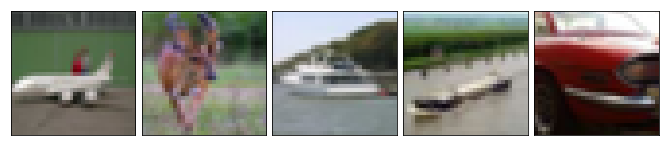

In [4]:
from keras.preprocessing.image import ImageDataGenerator

fig = plt.figure(figsize=(9, 15))
fig.subplots_adjust(left=0, right=1, bottom=0,
                    top=0.5, hspace=0.05, wspace=0.05)

for i in range(5):
    ax = fig.add_subplot(1, 5, i + 1, xticks=[], yticks=[])
    ax.imshow(x_train[i])

#### 3.1.2 左右にずらす

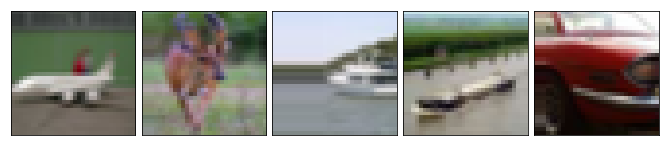

In [5]:
datagen = ImageDataGenerator(width_shift_range=0.4)

datagen.fit(x_train)

fig = plt.figure(figsize=(9, 15))
fig.subplots_adjust(left=0, right=1, bottom=0,
                    top=0.5, hspace=0.05, wspace=0.05)

for x_batch, y_batch in datagen.flow(x_train, y_train, batch_size=9, shuffle=False):
    for i in range(5):
        ax = fig.add_subplot(1, 5, i + 1, xticks=[], yticks=[])
        ax.imshow(x_batch[i])
    break

#### 3.1.3 上下にずらす

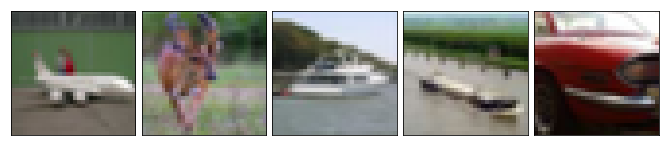

In [8]:
datagen = ImageDataGenerator(horizontal_flip=True)

datagen.fit(x_train)

fig = plt.figure(figsize=(9, 15))
fig.subplots_adjust(left=0, right=1, bottom=0,
                    top=0.5, hspace=0.05, wspace=0.05)

for x_batch, y_batch in datagen.flow(x_train, y_train, batch_size=9, shuffle=False):
    for i in range(5):
        ax = fig.add_subplot(1, 5, i + 1, xticks=[], yticks=[])
        ax.imshow(x_batch[i])
    break

#### 3.1.5 回転

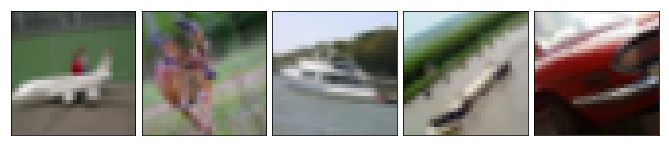

In [10]:
datagen = ImageDataGenerator(rotation_range=30)

datagen.fit(x_train)

fig = plt.figure(figsize=(9, 15))
fig.subplots_adjust(left=0, right=1, bottom=0,
                    top=0.5, hspace=0.05, wspace=0.05)

for x_batch, y_batch in datagen.flow(x_train, y_train, batch_size=9, shuffle=False):
    for i in range(5):
        ax = fig.add_subplot(1, 5, i + 1, xticks=[], yticks=[])
        ax.imshow(x_batch[i])
    break

その他、色々なdata augumentationが存在する。

keras ImageDataGenerator : https://keras.io/preprocessing/image/

### 3.2 画像データの正規化

実際の画像データはノイズなどがあり、画像間やピクセル間によって入力の値の分布が異なる。これを正規化することで入力層において特徴を抽出しやすくする。

kerasでの実装にはImageDataGeneratorを用いる。

#### 3.2.1 Global Contrast Normalizarion(GCN)

画像ごとにピクセルの値を平均0、分散1に正規化する。

$$
x^{norm} = \frac{x-\mu}{\sqrt{\sigma}}
$$

In [11]:
# 可視化用に値のrangeを[0, 1]に修正
def normalize(x):
    max_x = np.max(x, axis=(0, 1), keepdims=True)
    min_x = np.min(x, axis=(0, 1), keepdims=True)
    return (x - min_x) / (max_x - min_x)

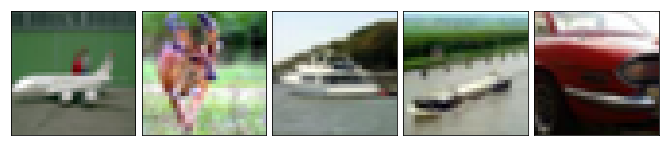

In [12]:
from keras.preprocessing.image import ImageDataGenerator

gcn_whitening = ImageDataGenerator(samplewise_center=True, samplewise_std_normalization=True)

gcn_whitening.fit(x_train)

fig = plt.figure(figsize=(9, 15))
fig.subplots_adjust(left=0, right=1, bottom=0, top=0.5, hspace=0.05, wspace=0.05)

for x_batch, y_batch in gcn_whitening.flow(x_train, y_train, batch_size=9, shuffle=False):
    for i in range(5):
        ax = fig.add_subplot(1, 5, i+1, xticks=[], yticks=[])
        ax.imshow(normalize(x_batch[i]))
    break

#### 3.2.2 Zero-phase Component Analysis(ZCA) Whitening

入力の各要素間の相関をゼロ(白色化)にする。

PCAを利用して共分散行列を単位行列化(分散1、共分散0)したのち、元の空間に戻す。

$$
x^{ZCA} = A\Lambda^{-\frac{1}{2}} \Lambda^T(x-\mu)
$$

C:\Users\yanor\Anaconda3\envs\matsuo\lib\site-packages\keras\preprocessing\image.py:645: UserWarning: This ImageDataGenerator specifies `zca_whitening`, which overrides setting of `featurewise_center`.
  warnings.warn('This ImageDataGenerator specifies '


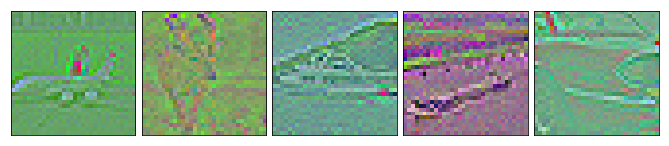

In [13]:
from keras.preprocessing.image import ImageDataGenerator

zca_whitening = ImageDataGenerator(zca_whitening=True)

zca_whitening.fit(x_train)

fig = plt.figure(figsize=(9, 15))
fig.subplots_adjust(left=0, right=1, bottom=0,
                    top=0.5, hspace=0.05, wspace=0.05)

for x_batch, y_batch in zca_whitening.flow(x_train, y_train, batch_size=9, shuffle=False):
    for i in range(5):
        ax = fig.add_subplot(1, 5, i + 1, xticks=[], yticks=[])
        ax.imshow(normalize(x_batch[i]))
    break

### 3.3 Batch Normalization

入力画像に対して正規化を行ったように、各隠れ層の入力の分布の安定させたいと考える。各隠れ層の入力を安定させないと、深層のネットワークにおいては層を重ねるほど分布が不安定となる。特に、深層学習において、学習データと検証(評価)データ間で各層の分布が変わってしまう現象は**内部共変量シフト**と呼ばれる。

**Batch Normalization**では各層の出力を正規化することでこの問題の解決を試みる。

ある層への入力を$X\in R^{H\times W\times C\times N}$ (H：縦の次元数、W：横の次元数、C：チャネル数、N：バッチサイズ)とすると、それぞれのチャンネルに対して平均・分散μ、$\sigma^2 \in R^{H\times W\times C}$ を計算しし、正規化を行う。

$$
\hat{X} = \frac{X-\mu}{\sigma}
$$

その後、平均・分散を調整する学習パラメータ $\gamma$、$\beta\in R^{H\times W\times C}$ を用いて出力を計算する。

$$
Y = \gamma \hat{X} + \beta
$$

これにより、各層の出力の分布を安定させることができる。

※後続の研究でBatch Normalizationは内部共変量シフトを軽減させる効果はほとんどないことが実験的に示されている。一方で、Batch Normalizationにより損失関数・勾配の形状が緩やかになり、勾配法などによる最適化が容易になることが実験的に・一部論理的に示されている。

kerasでは層としてBatchNormalizationが用意されているので、畳み込み層やプーリング層と同じようにレイヤとして追加するだけ。

```python
from keras.layers.normalization import BatchNormalization

...
model.add(BatchNormalization())
...

```

### 3.4 Skip Connection(Residual Network)

Skip Connection(Residual Network)は、層を飛び越えた結合をつくることで勾配消失問題を解決しようとする手法。

下図の様なイメージ。

![resblock](https://github.com/reminayano/matsuo/blob/master/lesson2/figures/resblock.png?raw=true)

上図のように、重みをかけずに値を渡し、逆伝播の再に出力層側から誤差をそのまま入力層側に伝えることで、勾配が消失しにくいネットワーク構造をつくっていると考えることができる。

kerasではFunctionalAPIを利用することで実装できる。

以下に実装例を示す。

```python

def resblock(x, filters=64, kernel_size=(3, 3)):
    x_ = Conv2D(filters, kernel_size, padding='same')(x)
    x_ = BatchNormalization()(x_)
    x_ = Conv2D(filters, kernel_size, padding='same')(x_)
    x = Add()([x_, x])
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    return x

from keras import backend as K

inputs = Input(shape=(32, 32, 3))

x = Conv2D(64, kernel_size=(5, 5), padding='same', activation='relu')(inputs)
x = resblock(x)
x = resblock(x)
x = Flatten()(x)
y = Dense(10, activation='softmax')(x)

model = Model(inputs=inputs, outputs=y)
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(x_train, y_train, batch_size=128, epochs=3, verbose=1)

```

### 3.5 学習済みネットワークの利用

前述の通り、畳み込みニューラルネットワークの入力層付近では局所的な特徴(エッジ等)を抽出している。これらの特徴は多くの画像データに共通している。

このことを利用し、あらかじめ大規模なデータセットで十分に学習されたネットワークの出力層以外の重みを初期値として活用することを考える。

kerasでは事前に大規模なデータセット(imageNet)に対して学区集されたモデルがロードできるようになってる。

```python

from keras.applications.vgg16 import VGG16

model = VGG16(weights='imagenet')
weights = [com.get_weights() for com in model.layers[1:]]
model = Sequential()

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', input_shape=(32, 32, 3))) # 32x32x3 -> 30x30x64
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu')) # 30x30x64 -> 28x28x64
model.add(MaxPooling2D(pool_size=(2, 2))) # 28x28x64 -> 14x14x64

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu')) # 14x14x64 -> 12x12x128
model.add(Conv2D(128, kernel_size=(3, 3), activation='relu')) # 12x12x128 -> 10x10x128
model.add(MaxPooling2D(pool_size=(2, 2))) # 10x10x128 -> 5x5x128

model.add(Flatten())
model.add(Dense(10, activation='softmax'))

```

上記のようにモデル構築したのち、ロードした重みを各層に設定する。

```python

# weightの初期化
model.layers[0].set_weights(weights[0])
model.layers[1].set_weights(weights[1])
model.layers[3].set_weights(weights[3])
model.layers[4].set_weights(weights[4])

```

### 3.6 学習させたモデルの保存・再利用

#### 3.6.1 保存

学習させたモデルはhdf5形式で保存することができる。

```python

model.save('./mnist_cnn.h5')

```

#### 3.6.2 再利用

保存されたモデルは以下のようにロードして再利用することができる。

```python

from keras.models import load_model

model = load_model('./mnist_cnn.h5')

y_pred = model.predict(x_valid)

```
